In [46]:
import torch
from transformers import pipeline
import nltk
import seaborn as sns
from lemminflect import getAllInflections, getAllLemmas
from nltk.corpus import wordnet as wn
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import semcor
from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Preparation

In [2]:
# load data
unmasker = pipeline('fill-mask', model='bert-base-uncased', top_k=10)
clear_output()

In [3]:
# test hugging face api
sentense = "Letters whose sole [MASK] is to make a political point will not be published."
candidate = unmasker(sentense)
result = []
for i in range(len(candidate)):
    result.append((candidate[i]['score'], candidate[i]['token_str']))
    
result

[(0.8293461203575134, 'purpose'),
 (0.06537206470966339, 'aim'),
 (0.026322776451706886, 'goal'),
 (0.013286333531141281, 'object'),
 (0.011476267129182816, 'function'),
 (0.009352428838610649, 'objective'),
 (0.009221878834068775, 'intention'),
 (0.0075449044816195965, 'intent'),
 (0.004589721094816923, 'task'),
 (0.004187294282019138, 'use')]

In [4]:
# load corpus 
with open('dataset/BAWE.txt', 'r', encoding='utf-8') as f:
    BAME_corpus = f.read().strip().split('. ')
with open('dataset/party_test.txt', 'r', encoding='utf-8') as f:
    party_test_corpus = f.read().strip().split('\n')
with open('dataset/party_train.txt', 'r', encoding='utf-8') as f:
    party_train_corpus = f.read().strip().split('\n')
    
corpuses = [BAME_corpus, party_test_corpus, party_train_corpus]
cor_names = ["BAME_corpus", "party_test_corpus", "party_train_corpus"]
c_len = len(cor_names)
for i in  range(c_len):
    print(cor_names[i], "len:", len(corpuses[i]))
    
corpus_combine = BAME_corpus + party_test_corpus + party_train_corpus

BAME_corpus len: 244506
party_test_corpus len: 70
party_train_corpus len: 637


In [5]:
# load AKL words
with open("data/noun.txt", 'r', encoding="utf-8") as f:
    noun = f.read().strip().split(', ')
with open("data/adj.txt", 'r', encoding="utf-8") as f:
    adj = f.read().strip().split(', ')
with open("data/adv.txt", 'r', encoding="utf-8") as f:
    adv = f.read().strip().split(', ')
with open("data/verb.txt", 'r', encoding="utf-8") as f:
    verb = f.read().strip().split(', ')
with open("data/others.txt", 'r', encoding="utf-8") as f:
    others = f.read().strip().split(', ')
    
AKL_words = [noun, adj, adv, verb, others]
AKL_merge = noun + adj + adv + verb + others
types = ["noun", "adj", "adv", "verb", "others"]

In [6]:
a_len = len(AKL_words)
for i in  range(a_len):
    print(types[i], "words:", len(AKL_words[i]))

noun words: 353
adj words: 180
adv words: 86
verb words: 233
others words: 75


# Function definition

In [7]:
def preprocess(text):
    """
    input: a string
    output: a list
    - transform to lower case
    - remove the punctuation
    - seperate the words by blank
    """
    text = text.lower()
    punc = '!()-[]{};:"\,<">./?@#$%^&*_~'
    for p in punc: 
        text = text.replace(p, "")
    return text

def check_word_exist(st, base_word):
    """"
    若st 中有base_word的任何變形，回傳True
    """
    tokens = st.split(' ')
    vairation = getAllInflections(base_word)
    var_list = set()
    for types in vairation:
        for item in vairation[types]:
            var_list.add(item)
        
    for item in var_list:
        if item in tokens:
            return True
    return False

def put_mask(sentense, base_word):
    """
    把 [MASK] 放到第一個出現的 `base_word`各種變形
    """
    tokens = sentense.split(' ')
    vairation = getAllInflections(base_word)
    var_list = set()
    for types in vairation:
        for item in vairation[types]:
            var_list.add(item)
            
    rep_tokens = []
    mask = 0 # Only put mask on the first appeared base word
    for token in tokens:
        add = 0
        for item in var_list:
            if token == item and mask== 0:
                rep_tokens.append("[MASK]")
                add = 1
                mask += 1
        if add == 0:
            rep_tokens.append(token)

    res_sent = " ".join(rep_tokens)
    return res_sent, var_list

unmasker = pipeline('fill-mask', model='bert-base-uncased', top_k=10)
def get_candidates(sentense, base_word):
    """
    所有`base_word`的變形都不會納入candidates
    """
    sentense, var_list = put_mask(sentense, base_word)
    candidate = unmasker(sentense)
    result = {}
    for i in range(len(candidate)):
        same = 0
        for item in var_list:
            if candidate[i]['token_str'] == item:
                same = 1
        if same == 0:
            result[candidate[i]['token_str']] = candidate[i]['score']
    return result

# 檢查是否是AKL字
def check_akl(word):
    if word in AKL_merge:
        return True
    return False

#得到相似度分數(use wup_similarity)
def get_similarity_score(base_word, syn_word):
    """
    return mean similarity score of this two words
    compare all meaning
    """
    base_sets = wn.synsets(base_word)
    syn_sets = wn.synsets(syn_word)
    n = len(base_sets)
    m = len(syn_sets)
    score = 0
    for i in range(n):
        for j in range(m):
            try:
                score += base_sets[i].wup_similarity(syn_sets[j])
            except:
                pass
    try:
        score = score/ (n*m)
    except:
        score = score / 1
    return score

# 把分太細的POS 縮小分類
verb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
adj = ['JJ', 'JJR', 'JJS']
adv = ['RB', 'RBR', 'RBS']
noun = ['NN', 'NNS', 'NNP', 'NNPS']

# 拿到句子中的詞性
def get_POS(sentense, target_word):
    """
    回傳 `target_word` 在 `sentense`中的詞性
    詞性種類: https://www.guru99.com/pos-tagging-chunking-nltk.html
    """
    # print("sentense: ", sentense)
    # print("target_word: ", target_word)
    tokens = nltk.word_tokenize(sentense)
    tag = nltk.pos_tag(tokens)
    # all variation 
    vairation = getAllInflections(target_word)
    var_list = set()
    for types in vairation:
        for item in vairation[types]:
            var_list.add(item)
    flag = 0
    mini_pos = ""
    # print(var_list)
    for tu in tag:
        for var in var_list:
            if tu[0] == var:
                mini_pos = tu[1]
                flag = 1
                break
        if flag == 1: # found
            break
    # print("mini_pos: ", mini_pos)
    pos = []
    if mini_pos in verb:
        pos.append("verb")
    if mini_pos in adj:
        pos.append("adj")
    if mini_pos in adv:
        pos.append("adv")
    if mini_pos in noun:
        pos.append("noun")
#     print(pos)
#     print('-'*10)
    return pos 

def same(cand_pos ,base_pos):
    for i in cand_pos:
        for j in base_pos:
            if i==j:
                return True
    return False

def get_all_variation(word):
    vairation = getAllInflections(word)
    var_list = set()
    for types in vairation:
        for item in vairation[types]:
            var_list.add(item)
    return var_list
    
def calculate_weight_ver2(cand, sentense, base_word):
    """
    input 1: the possible words dictionary
    input 2: the sentense used
    input 3: base word
    """
    data_items = cand.items()
    data_list = list(data_items)
    cand_df = pd.DataFrame(data_list, columns=['Words', 'Score'])
    
    # AKL part
    c_len = len(cand_df)
    for i in range(c_len):
        if check_akl(cand_df['Words'][i]):
            cand_df['Score'][i] = cand_df['Score'][i] *1.25
    base_pos = get_POS(sentense, base_word) #取得base的詞性
    vairation = getAllInflections(base_word)
    var_list = get_all_variation(base_word)

    for i in range(c_len): 
        sen_tokens = sentense.split()
        for var in var_list:
            if var in sen_tokens:
                sent_temp = sentense.replace(var, cand_df['Words'][i])
                break
        cand_pos = get_POS(sent_temp, cand_df['Words'][i]) #取得candidate的詞性
        if same(cand_pos ,base_pos):
            cand_df['Score'][i] = cand_df['Score'][i] *1.5
    # Wordnet Similarity
    for i in range(c_len):
        cand_df['Score'][i] += get_similarity_score(base_word, cand_df['Words'][i])
    
    cand_df = cand_df.sort_values(by=['Score'], ascending=False).reset_index(drop=True)
    return cand_df

# 找兩個字最近的字義
def find_sense_of_two_words(base_word, syn_word):
    base_word = wn.synsets(base_word) #可增加詞性 base_word = wn.synsets(base_word, pos=wn.VERB)  [VERB, NOUN, ADJ, ADV]
    syn_word = wn.synsets(syn_word) #可增加詞性 syn_word = wn.synsets(syn_word, pos=wn.VERB)  [VERB, NOUN, ADJ, ADV]
    wup_similarity=[]
    wup_similarity_dict={}
    for i in base_word:
        for j in syn_word:
            if wn.wup_similarity(i, j) != None:
                wup_similarity.append(wn.wup_similarity(i, j))
                wup_similarity_dict[wn.wup_similarity(i, j)]=[i,j]
    
    #找出相似度最大的值與sense
    try:
        similarity = max(wup_similarity)
    except:
        return None, None, None
    #sense編號 
    sense= wup_similarity_dict[max(wup_similarity)][0]
    #字義
    definition = wup_similarity_dict[max(wup_similarity)][0].definition()
    return similarity, sense, definition  #propose和need相似度, propose和need相似度最接近的sense編號, 字義 


def summary(sentence, base_word):
    """
    輸入: sentence, target word
    輸出: target word/ 例句/ 在此例句中找到最近的詞比對出來的字義 
    """
    cand = get_candidates(sentence, base_word) # 找出可能的答案 
    # print("candidate", cand)
    result_df = calculate_weight_ver2(cand, sentence, base_word) # 加權
    r_len = len(result_df['Words'])
    syn_final_word = ""
    for i in range(r_len):
        if(len(wn.synsets(result_df['Words'][i])))!= 0:
            syn_final_word = result_df['Words'][i] # 拿第一名的結果
            break
    # print("base_word: ", base_word, "syn_final_word", syn_final_word)
    similarity, sense, definition = find_sense_of_two_words(base_word, syn_final_word) # 找最近的字義
    if similarity == None:
        return None
    
    similar = sense.lemma_names()
    filter = []
    for tmp in similar:
        if tmp!=base_word:
            filter.append(tmp)
    result = '、'.join(filter)
    
    印出結果
    print(f"""
    Target Word：{base_word}

    例句：{sentence}

    --------------------

    在此例句中 "{base_word}" 的字義是：{definition} 
    
    以下列出同義字：{result}
    """)
    return sense

    # for demo
    # return definition, result

def get_lemma(sentence_idx, word_list):
    sent = semcor.tagged_sents(tag='sem')[sentence_idx]
    for word in sent:
        if(type(word)!=list):
            # print(word)
            for lf in word.leaves():
                lf = lf.lower()
                if lf in word_list:
                    try:
                        sense = word.label()
                        return sense.synset()
                    except:
                        return None

# Usage example

In [8]:
# Preprocess the sentences
corpus = []
for cor in corpus_combine:
    sentence = preprocess(cor)
    corpus.append(sentence)

In [9]:
base_word = "ability"

In [10]:
# get the sentense that contains base_word
filter_corpus = []
for cor in corpus: 
    if check_word_exist(cor, base_word): 
        filter_corpus.append(cor)
print("length of our base word sentense: ", len(filter_corpus))

length of our base word sentense:  1775


In [11]:
sentense = filter_corpus[1]

answer = summary(sentense, base_word)
print("sense:", answer)

sense: Synset('ability.n.02')


# Semcor

http://man.hubwiz.com/docset/NLTK.docset/Contents/Resources/Documents/api/nltk.corpus.reader.html#module-nltk.corpus.reader.semcor

https://www.nltk.org/api/nltk.corpus.reader.semcor.html

https://www.nltk.org/_modules/nltk/corpus/reader/semcor.html

https://www.nltk.org/howto/corpus.html#chunked-corpora

In [12]:
num_sents = len(semcor.sents()) # total number of sentences
num_sents

37176

In [13]:
" ".join(semcor.sents()[0]) # sentences

"The Fulton County Grand Jury said Friday an investigation of Atlanta 's recent primary election produced `` no evidence '' that any irregularities took place ."

# Evaluate

In [14]:
with open('dataset/sencor_sentenses.txt', 'r', encoding='utf-8') as f:
    semcor_text = f.read().split('\n')

In [15]:
# Preprocess the sentences
semcor_corpus = []
for cor in semcor_text:
    sentence = preprocess(cor)
    semcor_corpus.append(sentence)

In [16]:
candidates_words = ["star", "galley", "cone", "bass", "bow", "taste", "interest", "issue", "duty", "sentence", "slug"]

In [25]:
candidates = ["star", "taste"]

In [26]:
s_len = len(semcor_corpus)
mapping = {}
for word in candidates:
    base_word = word
    print(f"length of base word \"{base_word}\"")
    filter_cor_idx = []
    all_sense = set()
    for i in range(s_len): 
        if check_word_exist(semcor_corpus[i], base_word): 
            filter_cor_idx.append(i)
    for idx in filter_cor_idx:
        var_list = get_all_variation(base_word)
        ground_true = get_lemma(idx, var_list)
        all_sense.add(ground_true)
    mapping[base_word] = all_sense
    print(f"base word: {base_word}, sense: {all_sense}")

length of base word "star"
base word: star, sense: {Synset('star_of_david.n.01'), Synset('star.n.01'), None, Synset('star.v.01'), Synset('ace.n.03'), Synset('film_star.n.01'), Synset('leading.s.01'), Synset('star.n.04')}
length of base word "taste"
base word: taste, sense: {Synset('taste.n.04'), None, Synset('taste.n.03'), Synset('preference.n.01'), Synset('taste.n.01'), Synset('sample.v.01'), Synset('taste.v.02'), Synset('taste.v.01')}


In [27]:
mapping

{'star': {None,
  Synset('ace.n.03'),
  Synset('film_star.n.01'),
  Synset('leading.s.01'),
  Synset('star.n.01'),
  Synset('star.n.04'),
  Synset('star.v.01'),
  Synset('star_of_david.n.01')},
 'taste': {None,
  Synset('preference.n.01'),
  Synset('sample.v.01'),
  Synset('taste.n.01'),
  Synset('taste.n.03'),
  Synset('taste.n.04'),
  Synset('taste.v.01'),
  Synset('taste.v.02')}}

In [28]:
s_len = len(semcor_corpus)
for word in candidates_words:
    base_word = word
    filter_cor_idx = []
    numerator = 0
    denominator = 0
    for i in range(s_len): 
        if check_word_exist(semcor_corpus[i], base_word): 
            filter_cor_idx.append(i)
    print(f"length of base word \"{base_word}\" sentense: {len(filter_cor_idx)}")
    for idx in filter_cor_idx:
        sentense = semcor_corpus[idx]
        answer = summary(sentense, base_word)
        var_list = get_all_variation(base_word)
        ground_true = get_lemma(idx, var_list)
        if ground_true is None or answer is None:
            continue
        # print(answer, ground_true, idx)
        if answer == ground_true:
            # print("Same!")
            numerator += 1
            denominator += 1
        else:
            denominator += 1
    if denominator!= 0:
        acc = round(umerator/denominator, 2)
        print(f"{base_word}'s precision: {acc}")
    else:
        print("Not enough data.")
    print('-'*10)


length of base word "star" sentense: 49
star's precision: 0.68
----------
length of base word "galley" sentense: 2
Not enough data.
----------
length of base word "cone" sentense: 15
cone's precision: 0.47
----------
length of base word "bass" sentense: 13
bass's precision: 0.77
----------
length of base word "bow" sentense: 22
bow's precision: 0.68
----------
length of base word "taste" sentense: 52
taste's precision: 0.41
----------
length of base word "interest" sentense: 382
interest's precision: 0.87
----------
length of base word "issue" sentense: 168
issue's precision: 0.72
----------
length of base word "duty" sentense: 71
duty's precision: 0.78
----------
length of base word "sentence" sentense: 49
sentence's precision: 0.46
----------
length of base word "slug" sentense: 16
slug's precision: 0.8
----------



# Evaluate

In [17]:
acc_table = {
    "word":["star", "galley", "cone", "bass", "bow", "taste", "interest", "issue", "duty", "sentence", "slug"],
    "acc":[0.68, 0, 0.47, 0.77, 0.68, 0.41, 0.87, 0.72, 0.78, 0.46, 0.8],
    "num_sentences":[49, 2, 15, 13, 22, 52, 382, 168, 71, 49, 16]
}

model_df = pd.DataFrame(acc_table)

In [18]:
essay_table = {
    "word":["star", "galley", "cone", "bass", "bow", "taste", "interest", "issue", "duty", "sentence", "slug"],
    "acc":[0.96, 0.95, 0.77, 0.99, 0.91, 0.93, 0.72, 0.94, 0.96, 0.98, 0.97],
    "num_sentences":[1700, 42, 173, 227, 129, 308, 602, 868, 399, 341, 39]
}

essay_df = pd.DataFrame(essay_table)

In [19]:
essay_df['type'] = "essay"
model_df['type'] = "model"

<AxesSubplot:label='86b4b1cb-2c78-4921-9b5a-3195c461b18b', xlabel='word', ylabel='num_sentences'>

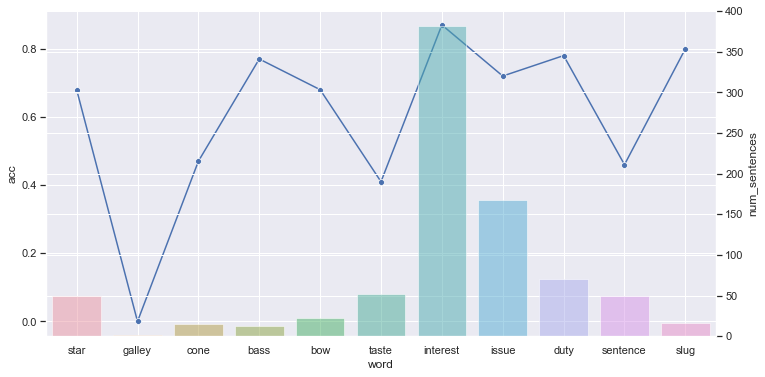

In [42]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = model_df, x='word', y='acc', marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data = model_df, x='word', y='num_sentences', alpha=0.5, ax=ax2)

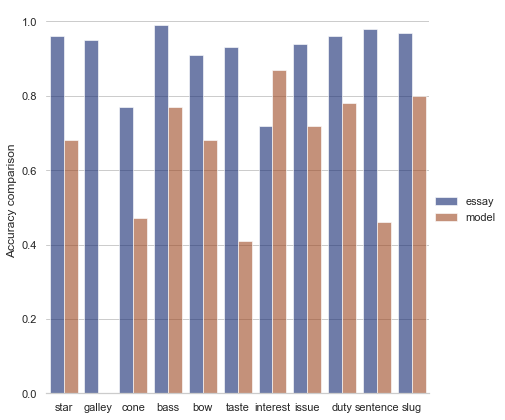

In [14]:
sns.set(style="whitegrid")

g = sns.catplot(
    data=summary_df, kind="bar",
    x="word", y="acc", hue="type",
    ci="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("", "Accuracy comparison")
g.legend.set_title("")

In [58]:
mapping = {
    "word":["star", "galley", "cone", "bass", "bow", "taste", "interest", "issue", "duty", "sentence", "slug"],
    "essay_meaning":[3, 3, 3, 2, 6, 2, 4, 3, 2, 2, 6],
    "semcor_meaning":[9, 4, 6, 4, 8, 6, 12, 9, 6, 9, 7]
}
mapping_df = pd.DataFrame(mapping)

In [59]:
mapping_df

,word,essay_meaning,semcor_meaning
0,star,3,9
1,galley,3,4
2,cone,3,6
3,bass,2,4
4,bow,6,8
5,taste,2,6
6,interest,4,12
7,issue,3,9
8,duty,2,6
9,sentence,2,9


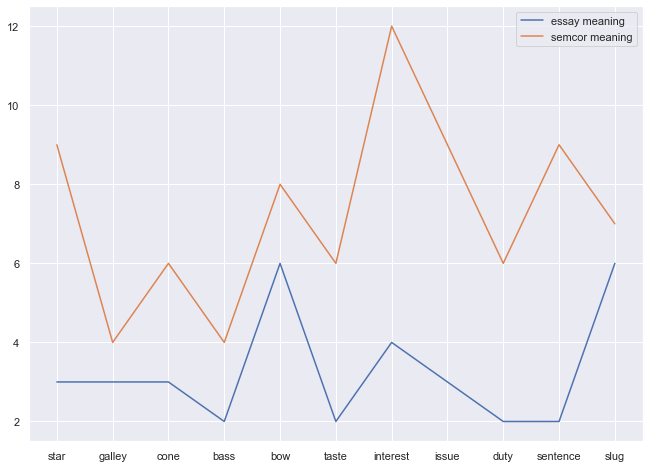

In [60]:
plt.plot(mapping_df['word'], mapping_df['essay_meaning'], label = "essay meaning")
plt.plot(mapping_df['word'], mapping_df['semcor_meaning'], label = "semcor meaning")
plt.legend()
plt.show()